# Train and Evaluate Tutorial

This notebook covers feature engineering, reward schemes, and training a DQN agent on trading data.

## 📚 Related Tutorials

Before diving in, review these essential tutorials:

| Tutorial | Description |
|----------|-------------|
| [First Training](../docs/tutorials/04-training/01-first-training.md) | Getting started with training |
| [Reward Schemes](../docs/tutorials/03-components/02-reward-schemes.md) | Why PBR works and reward design |
| [Common Failures](../docs/tutorials/02-domains/track-b-rl-for-traders/02-common-failures.md) | **Critical pitfalls to avoid** |
| [Overfitting](../docs/tutorials/05-advanced/01-overfitting.md) | Detection and prevention |
| [Commission Analysis](../docs/tutorials/05-advanced/02-commission.md) | Key finding: commission destroys profits |

### ⚠️ Important Warning

Our experiments show that agents **can predict market direction** (+$239 profit at 0% commission), but **overtrading destroys profits** when commission is applied (-$650 at 0.1% commission). See the [Commission Analysis](../docs/tutorials/05-advanced/02-commission.md) tutorial for details.

---

## Install TensorTrade

In [1]:
#!python3 -m pip install git+https://github.com/tensortrade-org/tensortrade.git

## Define global variables

In [1]:
n_steps = 1000
n_episodes = 20
window_size = 30
memory_capacity = n_steps * 10
save_path = 'agents/'
n_bins = 5             # Number of bins to partition the dataset evenly in order to evaluate class sparsity.
seed = 1337

## Setup Data Fetching

In [2]:
from tensortrade_platform.data.cdd import CryptoDataDownload

import warnings
import numpy as np
import pandas as pd

# Suppress deprecated pandas warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")
pd.set_option('future.no_silent_downcasting', True)

def prepare_data(df):
    df['volume'] = np.int64(df['volume'])
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['date'] = df['date'].dt.strftime('%Y-%m-%d %I:%M %p')
    return df

def fetch_data():
    cdd = CryptoDataDownload()
    bitfinex_data = cdd.fetch("Bitfinex", "BTC", "USD", "1h")
    bitfinex_data = bitfinex_data[['date', 'open', 'high', 'low', 'close', 'volume']]
    bitfinex_data = prepare_data(bitfinex_data)
    return bitfinex_data

def load_csv(filename):
    df = pd.read_csv('data/' + filename, skiprows=1)
    df.drop(columns=['symbol', 'volume_btc'], inplace=True)

    # Fix timestamp from "2019-10-17 09-AM" to "2019-10-17 09-00-00 AM"
    df['date'] = df['date'].str[:14] + '00-00 ' + df['date'].str[-2:]

    return prepare_data(df)

In [3]:
data = fetch_data()
data

Removed 1 duplicate timestamps


,date,open,high,low,close,volume
0,2018-05-15 06:00 AM,8723.8,8793.0,8714.9,8739.0,8988053
1,2018-05-15 07:00 AM,8739.0,8754.8,8719.3,8743.0,2288904
2,2018-05-15 08:00 AM,8743.0,8743.1,8653.2,8723.7,8891773
3,2018-05-15 09:00 AM,8723.7,8737.8,8701.2,8708.1,2054868
4,2018-05-15 10:00 AM,8708.1,8855.7,8695.8,8784.4,17309722
...,...,...,...,...,...,...
65041,2025-10-15 09:00 PM,111320.0,111500.0,110710.0,110960.0,5257176
65042,2025-10-15 10:00 PM,110970.0,111500.0,110830.0,110830.0,3081976
65043,2025-10-15 11:00 PM,110820.0,111180.0,110770.0,110920.0,3135737
65044,2025-10-16 12:00 AM,110950.0,111010.0,110540.0,110660.0,5250807


In [4]:
# pandas_ta is not used - the 'ta' library provides all needed indicators
# No additional installation needed

## Create features for the feed module

In [5]:
import os
import numpy as np
import ta

def fix_dataset_inconsistencies(dataframe, fill_value=None):
    dataframe = dataframe.replace([-np.inf, np.inf], np.nan)

    # This is done to avoid filling middle holes with backfilling.
    if fill_value is None:
        dataframe.iloc[0,:] = \
            dataframe.apply(lambda column: column.iloc[column.first_valid_index()], axis='index')
    else:
        dataframe.iloc[0,:] = \
            dataframe.iloc[0,:].fillna(fill_value)

    return dataframe.ffill().dropna(axis='columns')

def rsi(price: 'pd.Series[pd.Float64Dtype]', period: float) -> 'pd.Series[pd.Float64Dtype]':
    r = price.diff()
    upside = r.clip(lower=0)
    downside = -r.clip(upper=0)
    rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
    return 100*(1 - (1 + rs) ** -1)

def macd(price: 'pd.Series[pd.Float64Dtype]', fast: float, slow: float, signal: float) -> 'pd.Series[pd.Float64Dtype]':
    fm = price.ewm(span=fast, adjust=False).mean()
    sm = price.ewm(span=slow, adjust=False).mean()
    md = fm - sm
    signal = md - md.ewm(span=signal, adjust=False).mean()
    return signal

def generate_features(data):
    df = data.copy()

    # Generate all default indicators from ta library
    ta.add_all_ta_features(df, 
                            'open', 
                            'high', 
                            'low', 
                            'close', 
                            'volume', 
                            fillna=True)

    # Naming convention across most technical indicator libraries
    df = df.rename(columns={'open': 'Open', 
                                'high': 'High', 
                                'low': 'Low', 
                                'close': 'Close', 
                                'volume': 'Volume'})
    df = df.set_index('date')

    # Custom indicators
    features = pd.DataFrame.from_dict({
        'prev_open': df['Open'].shift(1),
        'prev_high': df['High'].shift(1),
        'prev_low': df['Low'].shift(1),
        'prev_close': df['Close'].shift(1),
        'prev_volume': df['Volume'].shift(1),
        'vol_5': df['Close'].rolling(window=5).std().abs(),
        'vol_10': df['Close'].rolling(window=10).std().abs(),
        'vol_20': df['Close'].rolling(window=20).std().abs(),
        'vol_30': df['Close'].rolling(window=30).std().abs(),
        'vol_50': df['Close'].rolling(window=50).std().abs(),
        'vol_60': df['Close'].rolling(window=60).std().abs(),
        'vol_100': df['Close'].rolling(window=100).std().abs(),
        'vol_200': df['Close'].rolling(window=200).std().abs(),
        'ma_5': df['Close'].rolling(window=5).mean(),
        'ma_10': df['Close'].rolling(window=10).mean(),
        'ma_20': df['Close'].rolling(window=20).mean(),
        'ma_30': df['Close'].rolling(window=30).mean(),
        'ma_50': df['Close'].rolling(window=50).mean(),
        'ma_60': df['Close'].rolling(window=60).mean(),
        'ma_100': df['Close'].rolling(window=100).mean(),
        'ma_200': df['Close'].rolling(window=200).mean(),
        'ema_5': ta.trend.ema_indicator(df['Close'], window=5, fillna=True),
        'ema_10': ta.trend.ema_indicator(df['Close'], window=10, fillna=True),
        'ema_20': ta.trend.ema_indicator(df['Close'], window=20, fillna=True),
        'ema_60': ta.trend.ema_indicator(df['Close'], window=60, fillna=True),
        'ema_64': ta.trend.ema_indicator(df['Close'], window=64, fillna=True),
        'ema_120': ta.trend.ema_indicator(df['Close'], window=120, fillna=True),
        'lr_open': np.log(df['Open']).diff().fillna(0),
        'lr_high': np.log(df['High']).diff().fillna(0),
        'lr_low': np.log(df['Low']).diff().fillna(0),
        'lr_close': np.log(df['Close']).diff().fillna(0),
        'r_volume': df['Close'].diff().fillna(0),
        'rsi_5': rsi(df['Close'], period=5),
        'rsi_10': rsi(df['Close'], period=10),
        'rsi_100': rsi(df['Close'], period=100),
        'rsi_7': rsi(df['Close'], period=7),
        'rsi_28': rsi(df['Close'], period=28),
        'rsi_6': rsi(df['Close'], period=6),
        'rsi_14': rsi(df['Close'], period=14),
        'rsi_26': rsi(df['Close'], period=24),
        'macd_normal': macd(df['Close'], fast=12, slow=26, signal=9),
        'macd_short': macd(df['Close'], fast=10, slow=50, signal=5),
        'macd_long': macd(df['Close'], fast=200, slow=100, signal=50),
    })

    # Concatenate custom features with ta-generated features
    data = pd.concat([df, features], axis='columns').ffill()

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # Revert naming convention
    data = data.rename(columns={'Open': 'open', 
                                'High': 'high', 
                                'Low': 'low', 
                                'Close': 'close', 
                                'Volume': 'volume'})

    data = data.reset_index()

    # A lot of indicators generate NaNs at the beginning of DataFrames, so remove them
    data = data.iloc[200:]
    data = data.reset_index(drop=True)

    data = fix_dataset_inconsistencies(data, fill_value=None)
    return data

In [6]:
data = generate_features(data)
data

,date,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,rsi_10,rsi_100,rsi_7,rsi_28,rsi_6,rsi_14,rsi_26,macd_normal,macd_short,macd_long
0,2018-05-23 02:00 PM,7897.3,7898.8,7849.8,7877.4,9341499,-1.219515e+08,-153103304,-0.175983,-1.548039e+08,...,37.137587,41.822047,41.132619,35.101143,43.092724,34.750094,34.457941,11.190548,10.871904,31.873058
1,2018-05-23 03:00 PM,7877.4,7889.7,7661.0,7700.0,23679375,-1.375548e+08,-176782679,-0.228723,-7.327921e+08,...,21.853878,39.139901,19.404595,28.683361,18.001296,23.664335,27.301151,1.333779,-5.426751,34.355233
2,2018-05-23 04:00 PM,7700.0,7700.1,7548.1,7605.4,42144843,-1.479246e+08,-218927522,-0.216859,-1.197665e+09,...,17.569645,37.832978,14.604874,26.049489,13.114764,20.000239,24.472798,-10.060459,-21.497215,37.504922
3,2018-05-23 05:00 PM,7605.4,7623.6,7441.8,7511.1,38711817,-1.571235e+08,-257639339,-0.221424,-1.548073e+09,...,14.435291,36.602356,11.342186,23.791122,9.900085,17.149659,22.092154,-21.778972,-36.146245,41.269618
4,2018-05-23 06:00 PM,7511.1,7551.6,7403.0,7489.1,23046091,-1.534634e+08,-280685430,-0.149460,-1.399351e+09,...,13.797253,36.323922,10.692061,23.302357,9.264339,16.556775,21.581086,-28.422775,-41.976877,44.917996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64841,2025-10-15 09:00 PM,111320.0,111500.0,110710.0,110960.0,5257176,1.114758e+10,-6860077230,-0.124668,-7.943209e+08,...,32.373793,44.171307,29.622491,40.253175,28.568645,35.184123,39.297038,-65.579183,-54.857915,112.449141
64842,2025-10-15 10:00 PM,110970.0,111500.0,110830.0,110830.0,3081976,1.114450e+10,-6863159206,-0.136256,-7.380831e+08,...,30.765152,44.019490,27.408468,39.671911,26.030757,34.010147,38.613173,-71.870601,-70.237035,117.961020
64843,2025-10-15 11:00 PM,110820.0,111180.0,110770.0,110920.0,3135737,1.114366e+10,-6860023469,-0.117275,-5.923261e+08,...,33.314074,44.153717,31.541188,40.290934,31.114581,35.611923,39.375327,-62.414190,-59.247345,121.781193
64844,2025-10-16 12:00 AM,110950.0,111010.0,110540.0,110660.0,5250807,1.114109e+10,-6865274276,-0.158900,-7.027380e+08,...,29.793295,43.846929,26.463412,39.089306,25.127660,33.111470,37.954803,-65.776993,-68.407626,127.330833


## Remove features with low variance before splitting the dataset

In [7]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
date = data[['date']].copy()
data = data.drop(columns=['date'])
sel.fit(data)
data[data.columns[sel.get_support(indices=True)]]
data = pd.concat([date, data], axis='columns')
data

,date,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,rsi_10,rsi_100,rsi_7,rsi_28,rsi_6,rsi_14,rsi_26,macd_normal,macd_short,macd_long
0,2018-05-23 02:00 PM,7897.3,7898.8,7849.8,7877.4,9341499,-1.219515e+08,-153103304,-0.175983,-1.548039e+08,...,37.137587,41.822047,41.132619,35.101143,43.092724,34.750094,34.457941,11.190548,10.871904,31.873058
1,2018-05-23 03:00 PM,7877.4,7889.7,7661.0,7700.0,23679375,-1.375548e+08,-176782679,-0.228723,-7.327921e+08,...,21.853878,39.139901,19.404595,28.683361,18.001296,23.664335,27.301151,1.333779,-5.426751,34.355233
2,2018-05-23 04:00 PM,7700.0,7700.1,7548.1,7605.4,42144843,-1.479246e+08,-218927522,-0.216859,-1.197665e+09,...,17.569645,37.832978,14.604874,26.049489,13.114764,20.000239,24.472798,-10.060459,-21.497215,37.504922
3,2018-05-23 05:00 PM,7605.4,7623.6,7441.8,7511.1,38711817,-1.571235e+08,-257639339,-0.221424,-1.548073e+09,...,14.435291,36.602356,11.342186,23.791122,9.900085,17.149659,22.092154,-21.778972,-36.146245,41.269618
4,2018-05-23 06:00 PM,7511.1,7551.6,7403.0,7489.1,23046091,-1.534634e+08,-280685430,-0.149460,-1.399351e+09,...,13.797253,36.323922,10.692061,23.302357,9.264339,16.556775,21.581086,-28.422775,-41.976877,44.917996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64841,2025-10-15 09:00 PM,111320.0,111500.0,110710.0,110960.0,5257176,1.114758e+10,-6860077230,-0.124668,-7.943209e+08,...,32.373793,44.171307,29.622491,40.253175,28.568645,35.184123,39.297038,-65.579183,-54.857915,112.449141
64842,2025-10-15 10:00 PM,110970.0,111500.0,110830.0,110830.0,3081976,1.114450e+10,-6863159206,-0.136256,-7.380831e+08,...,30.765152,44.019490,27.408468,39.671911,26.030757,34.010147,38.613173,-71.870601,-70.237035,117.961020
64843,2025-10-15 11:00 PM,110820.0,111180.0,110770.0,110920.0,3135737,1.114366e+10,-6860023469,-0.117275,-5.923261e+08,...,33.314074,44.153717,31.541188,40.290934,31.114581,35.611923,39.375327,-62.414190,-59.247345,121.781193
64844,2025-10-16 12:00 AM,110950.0,111010.0,110540.0,110660.0,5250807,1.114109e+10,-6865274276,-0.158900,-7.027380e+08,...,29.793295,43.846929,26.463412,39.089306,25.127660,33.111470,37.954803,-65.776993,-68.407626,127.330833


## Split dataset

In [8]:
from sklearn.model_selection import train_test_split

def split_data(data):
    X = data.copy()
    y = X['close'].pct_change()

    X_train_test, X_valid, y_train_test, y_valid = \
        train_test_split(data, data['close'].pct_change(), train_size=0.67, test_size=0.33, shuffle=False)

    X_train, X_test, y_train, y_test = \
        train_test_split(X_train_test, y_train_test, train_size=0.50, test_size=0.50, shuffle=False)

    return X_train, X_test, X_valid, y_train, y_test, y_valid

In [9]:
X_train, X_test, X_valid, y_train, y_test, y_valid = \
    split_data(data)

import os
cwd = os.getcwd()
train_csv = os.path.join(cwd, 'train.csv')
test_csv = os.path.join(cwd, 'test.csv')
valid_csv = os.path.join(cwd, 'valid.csv')
X_train.to_csv(train_csv, index=False)
X_test.to_csv(test_csv, index=False)
X_valid.to_csv(valid_csv, index=False)

## Get dataset statistics

In [10]:
from scipy.stats import iqr

def estimate_outliers(data):
    return iqr(data) * 1.5

def estimate_percent_gains(data, column='close'):
    returns = get_returns(data, column=column)
    gains = estimate_outliers(returns)
    return gains

def get_returns(data, column='close'):
    return fix_dataset_inconsistencies(data[[column]].pct_change(), fill_value=0)

def precalculate_ground_truths(data, column='close', threshold=None):
    returns = get_returns(data, column=column)
    gains = estimate_outliers(returns) if threshold is None else threshold
    binary_gains = (returns[column] > gains).astype(int)
    return binary_gains

def is_null(data):
    return data.isnull().sum().sum() > 0

def is_sparse(data, column='close'):
    binary_gains = precalculate_ground_truths(data, column=column)
    bins = [n * (binary_gains.shape[0] // n_bins) for n in range(n_bins)]
    bins += [binary_gains.shape[0]]
    bins = [binary_gains.iloc[bins[n]:bins[n + 1]] for n in range(n_bins)]
    return all([bin.astype(bool).any() for bin in bins])

def is_data_predictible(data, column):
    return not is_null(data) & is_sparse(data, column)

data.describe(include='all')

,date,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,rsi_10,rsi_100,rsi_7,rsi_28,rsi_6,rsi_14,rsi_26,macd_normal,macd_short,macd_long
count,64846,64846.000000,64846.000000,64846.000000,64846.000000,6.484600e+04,6.484600e+04,6.484600e+04,64846.000000,6.484600e+04,...,64846.000000,64846.000000,64846.000000,64846.000000,64846.000000,64846.000000,64846.000000,64846.000000,64846.000000,64846.000000
unique,64846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2018-05-23 02:00 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,37039.606345,37180.326441,36893.126508,37041.127523,5.615613e+06,6.620764e+09,-3.765267e+09,0.019781,-1.487432e+08,...,50.795605,50.667975,50.830921,50.712567,50.846559,50.763516,50.721293,-0.022464,-0.028657,0.594255
std,NaN,31311.945332,31403.879863,31217.519897,31312.937506,1.181675e+07,4.658747e+09,2.214608e+09,0.187960,4.183275e+09,...,14.091045,5.318974,16.348063,9.203130,17.456962,12.268458,9.816546,90.637016,97.220904,184.760055
min,NaN,3229.800000,3247.100000,3215.200000,3229.800000,0.000000e+00,-7.758610e+08,-6.868621e+09,-0.933971,-2.669366e+11,...,3.031585,23.806862,1.535615,10.485117,1.080053,5.106820,9.203282,-939.004278,-998.671739,-1125.030647
25%,NaN,9643.817500,9675.175000,9606.745000,9644.075000,7.995065e+05,1.091775e+09,-6.108678e+09,-0.100635,-1.292063e+08,...,41.702532,47.210387,39.904026,44.911006,39.025700,42.992923,44.559975,-24.220213,-24.929356,-57.334725
50%,NaN,28025.000000,28138.000000,27936.500000,28024.000000,2.181134e+06,8.952633e+09,-4.292704e+09,0.020448,-1.362531e+06,...,50.777144,50.415190,50.870726,50.618726,50.964230,50.731234,50.636986,-0.102125,-0.151354,-0.281901
75%,NaN,56519.750000,56806.000000,56214.250000,56516.750000,5.679905e+06,1.030106e+10,-1.575081e+09,0.140846,1.028971e+08,...,59.840565,53.942504,61.675241,56.421688,62.658124,58.408164,56.755413,22.568792,23.474857,57.693997


## Evaluate outlier sparsity of the data

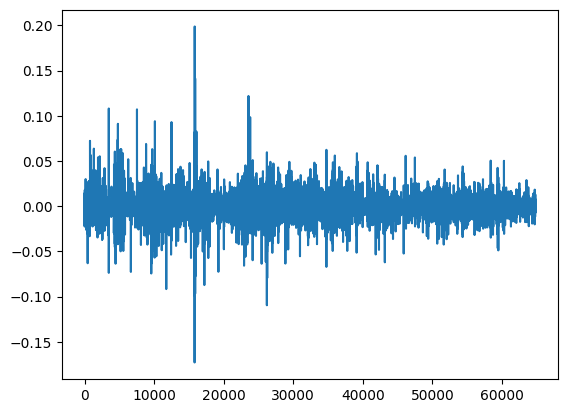

True

In [11]:
import matplotlib.pyplot as plt
plt.plot(get_returns(data, column='close'))
plt.show()
is_data_predictible(data, 'close')

## Percentage of the dataset generating rewards (keep between 5% to 15% or just rely on is_data_predictible())

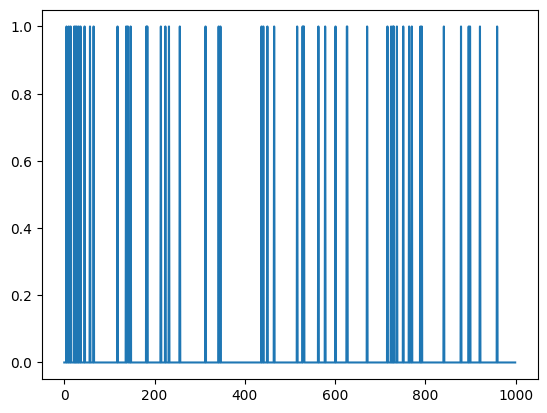

8.11%


In [12]:
plt.plot(precalculate_ground_truths(data, column='close').iloc[:1000])
plt.show()
percent_rewardable = str(round(100 + precalculate_ground_truths(data, column='close').value_counts().pct_change().iloc[-1] * 100, 2)) + '%'
print(percent_rewardable)

## Threshold to pass to AnomalousProfit reward scheme

In [13]:
X_train_test = pd.concat([X_train, X_test], axis='index')
#threshold = estimate_percent_gains(X_train_test, 'close')
threshold = estimate_percent_gains(X_train, 'close')
threshold

0.007057635543548574

## Implement basic feature engineering

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from feature_engine.selection import SelectBySingleFeaturePerformance

In [15]:
rf = RandomForestClassifier(n_estimators=100, 
                            random_state=seed, 
                            n_jobs=6)

sel = SelectBySingleFeaturePerformance(variables=None, 
                                       estimator=rf, 
                                       scoring="roc_auc", 
                                       cv=5, 
                                       threshold=0.5)

sel.fit(X_train, precalculate_ground_truths(X_train, column='close'))

,estimator,RandomForestC...om_state=1337)
,scoring,'roc_auc'
,cv,5
,groups,None
,threshold,0.5
,variables,None
,confirm_variables,False
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",10
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2


In [16]:
feature_performance = pd.Series(sel.feature_performance_).sort_values(ascending=False)
feature_performance

lr_close                   0.999664
others_dlr                 0.999664
others_dr                  0.999664
r_volume                   0.934236
lr_high                    0.803363
                             ...   
trend_psar_down            0.405327
trend_ichimoku_base        0.402601
volatility_dcl             0.400003
volatility_dch             0.395777
trend_visual_ichimoku_b    0.388439
Length: 134, dtype: float64

Text(0, 0.5, 'roc-auc')

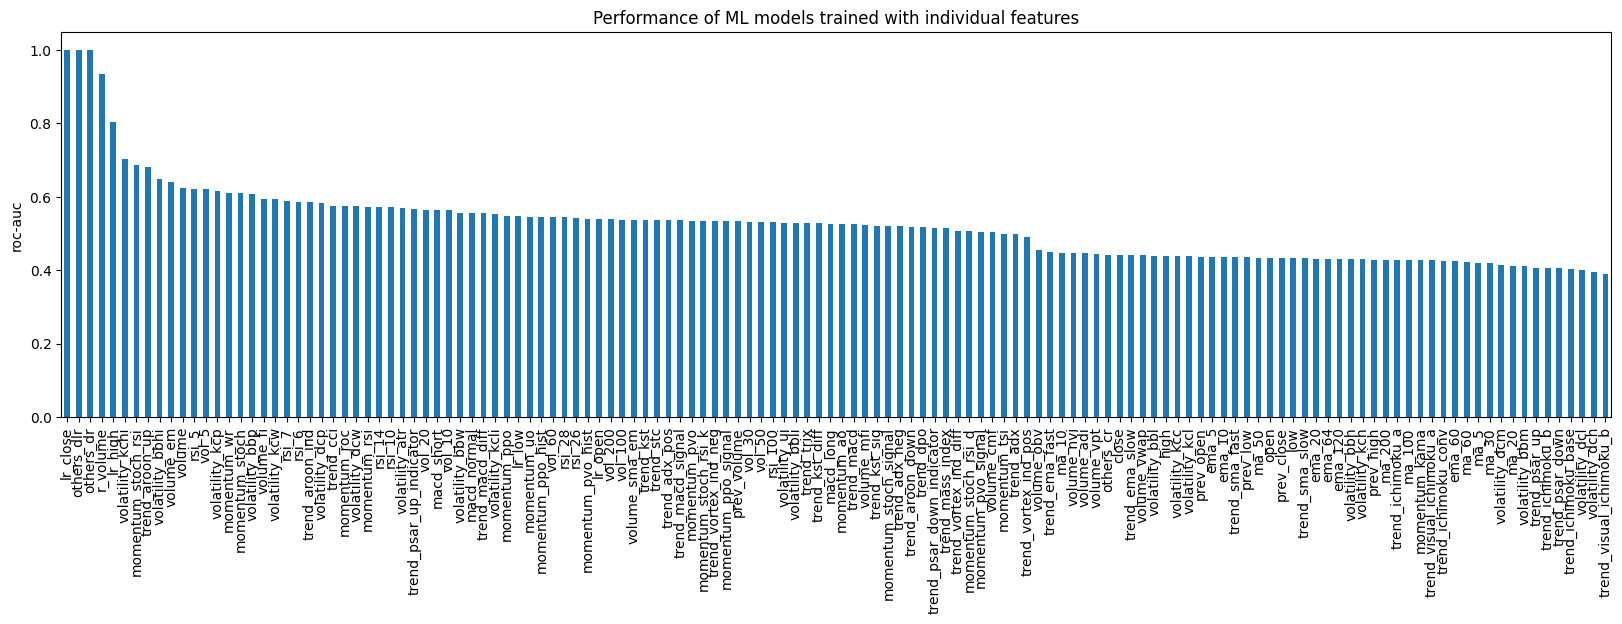

In [17]:
feature_performance.plot.bar(figsize=(20, 5))
plt.title('Performance of ML models trained with individual features')
plt.ylabel('roc-auc')

In [18]:
features_to_drop = sel.features_to_drop_
features_to_drop

['open',
 'high',
 'low',
 'close',
 'volume_adi',
 'volume_obv',
 'volume_vpt',
 'volume_vwap',
 'volume_nvi',
 'volatility_bbm',
 'volatility_bbh',
 'volatility_bbl',
 'volatility_kcc',
 'volatility_kch',
 'volatility_kcl',
 'volatility_dcl',
 'volatility_dch',
 'volatility_dcm',
 'trend_sma_fast',
 'trend_sma_slow',
 'trend_ema_fast',
 'trend_ema_slow',
 'trend_vortex_ind_pos',
 'trend_ichimoku_conv',
 'trend_ichimoku_base',
 'trend_ichimoku_a',
 'trend_ichimoku_b',
 'trend_adx',
 'trend_visual_ichimoku_a',
 'trend_visual_ichimoku_b',
 'trend_psar_up',
 'trend_psar_down',
 'momentum_tsi',
 'momentum_kama',
 'others_cr',
 'prev_open',
 'prev_high',
 'prev_low',
 'prev_close',
 'ma_5',
 'ma_10',
 'ma_20',
 'ma_30',
 'ma_50',
 'ma_60',
 'ma_100',
 'ma_200',
 'ema_5',
 'ema_10',
 'ema_20',
 'ema_60',
 'ema_64',
 'ema_120']

In [19]:
to_drop = list(set(features_to_drop) - set(['open', 'high', 'low', 'close', 'volume']))
len(to_drop)

49

In [20]:
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)
X_valid = X_valid.drop(columns=to_drop)

X_train.shape, X_test.shape, X_valid.shape

((21723, 86), (21723, 86), (21400, 86))

In [21]:
X_train.columns.tolist()

['date',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'volume_cmf',
 'volume_fi',
 'volume_em',
 'volume_sma_em',
 'volume_mfi',
 'volatility_bbw',
 'volatility_bbp',
 'volatility_bbhi',
 'volatility_bbli',
 'volatility_kcw',
 'volatility_kcp',
 'volatility_kchi',
 'volatility_kcli',
 'volatility_dcw',
 'volatility_dcp',
 'volatility_atr',
 'volatility_ui',
 'trend_macd',
 'trend_macd_signal',
 'trend_macd_diff',
 'trend_vortex_ind_neg',
 'trend_vortex_ind_diff',
 'trend_trix',
 'trend_mass_index',
 'trend_dpo',
 'trend_kst',
 'trend_kst_sig',
 'trend_kst_diff',
 'trend_stc',
 'trend_adx_pos',
 'trend_adx_neg',
 'trend_cci',
 'trend_aroon_up',
 'trend_aroon_down',
 'trend_aroon_ind',
 'trend_psar_up_indicator',
 'trend_psar_down_indicator',
 'momentum_rsi',
 'momentum_stoch_rsi',
 'momentum_stoch_rsi_k',
 'momentum_stoch_rsi_d',
 'momentum_uo',
 'momentum_stoch',
 'momentum_stoch_signal',
 'momentum_wr',
 'momentum_ao',
 'momentum_roc',
 'momentum_ppo',
 'momentum_ppo_signal',
 'mom

## Normalize the dataset subsets to make the model converge faster

In [22]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

scaler_type = MinMaxScaler

def get_feature_scalers(X, scaler_type=scaler_type):
    scalers = []
    for name in list(X.columns[X.columns != 'date']):
        scalers.append(scaler_type().fit(X[name].values.reshape(-1, 1)))
    return scalers

def get_scaler_transforms(X, scalers):
    X_scaled = []
    for name, scaler in zip(list(X.columns[X.columns != 'date']), scalers):
        X_scaled.append(scaler.transform(X[name].values.reshape(-1, 1)))
    X_scaled = pd.concat([pd.DataFrame(column, columns=[name]) for name, column in \
                          zip(list(X.columns[X.columns != 'date']), X_scaled)], axis='columns')
    return X_scaled

def normalize_data(X_train, X_test, X_valid):
    X_train_test = pd.concat([X_train, X_test], axis='index')
    X_train_test_valid = pd.concat([X_train_test, X_valid], axis='index')

    X_train_test_dates = X_train_test[['date']]
    X_train_test_valid_dates = X_train_test_valid[['date']]

    X_train_test = X_train_test.drop(columns=['date'])
    X_train_test_valid = X_train_test_valid.drop(columns=['date'])

    train_test_scalers = \
        get_feature_scalers(X_train_test, 
                            scaler_type=scaler_type)
    train_test_valid_scalers = \
        get_feature_scalers(X_train_test_valid, 
                            scaler_type=scaler_type)

    X_train_test_scaled = \
        get_scaler_transforms(X_train_test, 
                              train_test_scalers)
    X_train_test_valid_scaled = \
        get_scaler_transforms(X_train_test_valid, 
                              train_test_scalers)
    X_train_test_valid_scaled_leaking = \
        get_scaler_transforms(X_train_test_valid, 
                              train_test_valid_scalers)

    X_train_test_scaled = \
        pd.concat([X_train_test_dates, 
                   X_train_test_scaled], 
                  axis='columns')
    X_train_test_valid_scaled = \
        pd.concat([X_train_test_valid_dates, 
                   X_train_test_valid_scaled], 
                  axis='columns')
    X_train_test_valid_scaled_leaking = \
        pd.concat([X_train_test_valid_dates, 
                   X_train_test_valid_scaled_leaking], 
                  axis='columns')

    X_train_scaled = X_train_test_scaled.iloc[:X_train.shape[0]]
    X_test_scaled = X_train_test_scaled.iloc[X_train.shape[0]:]
    X_valid_scaled = X_train_test_valid_scaled.iloc[X_train_test.shape[0]:]
    X_valid_scaled_leaking = X_train_test_valid_scaled_leaking.iloc[X_train_test.shape[0]:]

    return (train_test_scalers, 
            train_test_valid_scalers, 
            X_train_scaled, 
            X_test_scaled, 
            X_valid_scaled, 
            X_valid_scaled_leaking)

In [23]:
train_test_scalers, train_test_valid_scalers, X_train_scaled, X_test_scaled, X_valid_scaled, X_valid_scaled_leaking = \
    normalize_data(X_train, X_test, X_valid)

## Write a reward scheme encouraging rare volatile upside trades

In [24]:
from tensortrade.env.default.rewards import TensorTradeRewardScheme


class AnomalousProfit(TensorTradeRewardScheme):
    """A simple reward scheme that rewards the agent for exceeding a 
    precalculated percentage in the net worth.

    Parameters
    ----------
    threshold : float
        The minimum value to exceed in order to get the reward.

    Attributes
    ----------
    threshold : float
        The minimum value to exceed in order to get the reward.
    """

    registered_name = "anomalous"

    def __init__(self, threshold: float = 0.02, window_size: int = 1):
        self._window_size = self.default('window_size', window_size)
        self._threshold = self.default('threshold', threshold)

    def get_reward(self, portfolio: 'Portfolio') -> float:
        """Rewards the agent for incremental increases in net worth over a
        sliding window.

        Parameters
        ----------
        portfolio : `Portfolio`
            The portfolio being used by the environment.

        Returns
        -------
        int
            Whether the last percent change in net worth exceeds the predefined 
            `threshold`.
        """
        performance = pd.DataFrame.from_dict(portfolio.performance).T
        current_step = performance.shape[0]
        if current_step > 1:
            # Hint: make it cumulative.
            net_worths = performance['net_worth']
            ground_truths = precalculate_ground_truths(performance, 
                                                       column='net_worth', 
                                                       threshold=self._threshold)
            reward_factor = 2.0 * ground_truths - 1.0
            #return net_worths.iloc[-1] / net_worths.iloc[-min(current_step, self._window_size + 1)] - 1.0
            return (reward_factor * net_worths.abs()).iloc[-1]

        else:
            return 0.0

In [25]:
class PenalizedProfit(TensorTradeRewardScheme):
    """A reward scheme which penalizes net worth loss and 
    decays with the time spent.

    Parameters
    ----------
    cash_penalty_proportion : float
        cash_penalty_proportion

    Attributes
    ----------
    cash_penalty_proportion : float
        cash_penalty_proportion.
    """

    registered_name = "penalized"

    def __init__(self, cash_penalty_proportion: float = 0.10):
        self._cash_penalty_proportion = \
            self.default('cash_penalty_proportion', 
                         cash_penalty_proportion)

    def get_reward(self, portfolio: 'Portfolio') -> float:
        """Rewards the agent for gaining net worth while holding the asset.

        Parameters
        ----------
        portfolio : `Portfolio`
            The portfolio being used by the environment.

        Returns
        -------
        int
            A penalized reward.
        """
        performance = pd.DataFrame.from_dict(portfolio.performance).T
        current_step = performance.shape[0]
        if current_step > 1:
            initial_amount = portfolio.initial_net_worth
            net_worth = performance['net_worth'].iloc[-1]
            cash_worth = performance['bitstamp:/USD:/total'].iloc[-1]
            cash_penalty = max(0, (net_worth * self._cash_penalty_proportion - cash_worth))
            net_worth -= cash_penalty
            reward = (net_worth / initial_amount) - 1
            reward /= current_step
            return reward
        else:
            return 0.0

## TODO: implement tuning

## Setup Trading Environment

In [26]:
import tensortrade.env.default as default

from tensortrade.agents import DQNAgent
from tensortrade.feed.core import DataFeed, Stream
from tensortrade.feed.core.base import NameSpace
from tensortrade.env.default.actions import BSH
from tensortrade.env.default.rewards import RiskAdjustedReturns, SimpleProfit
from tensortrade.oms.exchanges import Exchange, ExchangeOptions
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC, ETH
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.oms.orders import TradeType

# TODO: adjust according to your commission percentage, if present
commission = 0.001
price = Stream.source(list(X_train["close"]), 
                      dtype="float").rename("USD-BTC")
#bitstamp_options = ExchangeOptions(commission=commission)
#bitstamp = Exchange("bitstamp", 
#                    service=execute_order, 
#                    options=bitstamp_options)(price)
bitstamp = Exchange("bitstamp", 
                    service=execute_order)(price)

cash = Wallet(bitstamp, 50000 * USD)
asset = Wallet(bitstamp, 0 * BTC)

portfolio = Portfolio(USD, [cash, asset])

with NameSpace("bitstamp"):
    features = [
        Stream.source(list(X_train_scaled[c]), 
                      dtype="float").rename(c) for c in X_train_scaled.columns[1:]
        #Stream.source(list(X_train_scaled['lr_close']), dtype="float").rename('lr_close')
    ]

feed = DataFeed(features)
feed.compile()

renderer_feed = DataFeed([
    Stream.source(list(X_train["date"])).rename("date"),
    Stream.source(list(X_train["open"]), dtype="float").rename("open"),
    Stream.source(list(X_train["high"]), dtype="float").rename("high"),
    Stream.source(list(X_train["low"]), dtype="float").rename("low"),
    Stream.source(list(X_train["close"]), dtype="float").rename("close"), 
    Stream.source(list(X_train["volume"]), dtype="float").rename("volume") 
])

action_scheme = BSH(
    cash=cash,
    asset=asset
)

#reward_scheme = RiskAdjustedReturns(return_algorithm='sortino',
#                                    window_size=30)

#reward_scheme = SimpleProfit(window_size=30)

reward_scheme = AnomalousProfit(threshold=threshold)

#reward_scheme = PenalizedProfit(cash_penalty_proportion=0.1)

env = default.create(
    portfolio=portfolio,
    action_scheme=action_scheme,
    reward_scheme=reward_scheme,
    feed=feed,
    renderer_feed=renderer_feed,
    renderer=default.renderers.PlotlyTradingChart(),
    window_size=30
)

In [27]:
env.observer.feed.next()

{'internal': {'bitstamp:/USD-BTC': 7877.4,
  'bitstamp:/USD:/free': 50000.0,
  'bitstamp:/USD:/locked': 0.0,
  'bitstamp:/USD:/total': 50000.0,
  'bitstamp:/BTC:/free': 0.0,
  'bitstamp:/BTC:/locked': 0.0,
  'bitstamp:/BTC:/total': 0.0,
  'bitstamp:/BTC:/worth': 0.0,
  'net_worth': 50000.0},
 'external': {'bitstamp:/open': 0.07139994370609687,
  'bitstamp:/high': 0.0707903863742545,
  'bitstamp:/low': 0.07104490241404895,
  'bitstamp:/close': 0.07109552830604302,
  'bitstamp:/volume': 0.019187259203362988,
  'bitstamp:/volume_cmf': 0.36495256768099704,
  'bitstamp:/volume_fi': 0.7328878736813128,
  'bitstamp:/volume_em': 0.037193222216778316,
  'bitstamp:/volume_sma_em': 0.04317229619570243,
  'bitstamp:/volume_mfi': 0.30389505331139943,
  'bitstamp:/volatility_bbw': 0.08096534797891425,
  'bitstamp:/volatility_bbp': 0.42721901509721405,
  'bitstamp:/volatility_bbhi': 0.0,
  'bitstamp:/volatility_bbli': 0.0,
  'bitstamp:/volatility_kcw': 0.0651879119324374,
  'bitstamp:/volatility_kcp'

## Setup and Train DQN Agent

In [28]:
def get_optimal_batch_size(window_size=30, n_steps=1000, batch_factor=4, stride=1):
    """
    lookback = 30          # Days of past data (also named window_size).
    batch_factor = 4       # batch_size = (sample_size - lookback - stride) // batch_factor
    stride = 1             # Time series shift into the future.
    """
    lookback = window_size
    sample_size = n_steps
    batch_size = ((sample_size - lookback - stride) // batch_factor)
    return batch_size

batch_size = get_optimal_batch_size(window_size=window_size, n_steps=n_steps, batch_factor=4)
batch_size

242

In [29]:
agent = DQNAgent(env)

agent.train(batch_size=batch_size, 
            n_steps=n_steps, 
            n_episodes=n_episodes, 
            memory_capacity=memory_capacity, 
            save_path=save_path)

/tmp/ipykernel_166/1908556242.py:1: DeprecationWarning: Call to deprecated class DQNAgent. (Builtin agents are being deprecated in favor of external implementations (ie: Ray)) -- Deprecated since version 1.0.4.
  agent = DQNAgent(env)


====      AGENT ID: d1ed2938-a151-4298-955c-e9e2199b888e      ====


2026-02-10 00:17:42.876092: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 10364928 exceeds 10% of free system memory.
2026-02-10 00:17:42.878703: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 10364928 exceeds 10% of free system memory.
2026-02-10 00:17:42.886976: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 10364928 exceeds 10% of free system memory.
2026-02-10 00:17:42.887675: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 10364928 exceeds 10% of free system memory.
2026-02-10 00:17:42.901829: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 15384320 exceeds 10% of free system memory.


FigureWidget({
    'data': [{'name': 'Price',
              'showlegend': False,
              'type': 'candlestick',
              'uid': 'a85e3f4b-a585-4986-9c39-f88df4b484ce',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'marker': {'color': 'DodgerBlue'},
              'name': 'Volume',
              'showlegend': False,
              'type': 'bar',
              'uid': 'cf85f2aa-d6dc-4259-a806-8067cbb39cc9',
              'xaxis': 'x2',
              'yaxis': 'y2'},
             {'mode': 'lines',
              'name': 'bitstamp:/USD-BTC',
              'type': 'scatter',
              'uid': 'f1f8fe02-b991-4fa2-81a3-de86b9cd33d7',
              'xaxis': 'x3',
              'yaxis': 'y3'},
             {'mode': 'lines',
              'name': 'bitstamp:/USD:/free',
              'type': 'scatter',
              'uid': '8387c879-fc33-4b48-b99e-cac0c9a13225',
              'xaxis': 'x3',
              'yaxis': 'y3'},
             {'mode': 'lines',
            

KeyboardInterrupt: 

## Implement validation here

## Print basic quantstats report